# Automated Patent Landscaping

This Jupyter Notebook walks through the creation of `Automated Patent Landscapes`, based on the paper published in [_Workshop on Legal Text, Document , and Corpus Analytics - LTDCA 2016_](https://drive.google.com/file/d/0BwAXGAx2LKMpWVIzUm5XMVNuYnM/view).

## Requirements
Before we get started, you should install some requirements for running this notebook. We rely on TensorFlow and Google's Cloud infrastructure such as BigQuery, where we pull public patent data, and that needs to be installed and authorized. You need a few basics before continuing:
* Anaconda
* Jupyter Notebooks
* TensorFlow
* Google Cloud SDK
* BigQuery Python Client
* A few Python utilities

### Anaconda
I strongly recommend using Anaconda for this - it helps manage environments for Python, and these instructions will assume you're using it. Download Anaconda from [https://www.continuum.io/downloads](https://www.continuum.io/downloads).

Once Anaconda is installed, create an environment:
```
conda create -n patent-landscape python=3.6
source activate patent-landscape (or just: activate patent-landscape if you're in Windows)
```

### Jupyter Notebooks

To run the code in this notebook, you'll also need to install Jupyter. The following installs Jupyter and some utilities that let you toggle between different conda environments while inside a notebook.

```
conda config --add channels conda-forge
conda install jupyter ipython nb_conda=2.2.0
```

### TensorFlow

TensorFlow will work 'out of the box' with just your CPU. Since we're going to be building a model using neural networks, however, I highly recommend using GPU acceleration - training will be at least an order of magnitude faster with a modern GPU. You'll need to follow the TensorFlow instructions found [here](https://www.tensorflow.org/install/) for your platform. There are several steps to getting your GPU working for Deep Learning, so pay careful attention to the instructions. Note that only Nvidia chipset-based GPUs will work with TensorFlow.

To skip all the GPU acceleration and just get started, you can just run this command within your active conda environment:
```
pip install tensorflow
```

Also install tflearn, the high-level library on top of TensorFlow:
```
pip install tflearn
```

### Google Cloud SDK
Download and install Google Cloud SDK. You can download and install using [these](https://cloud.google.com/sdk/docs) instructions, or more conveniently:

```
pip install google-cloud
```

Once you have the `gcloud` client installed, you need to authorize it to access Google's Cloud on your behalf. From your active conda environment, run this command and follow the prompts:
```
gcloud auth application-default login
```

### BigQuery Python Client
```
pip install google-cloud-bigquery
```

### Python Utilities

```
conda install numpy pandas h5py scipy scikit-learn matplotlib
```

## Creating a Patent Landscape

The figure 1 shows the high level flow to create a patent landscape. We'll walk through each of these in turn in the notebook below.
![Fig 1. High Level Flow of Automated Patent Landscaping](figs/flow.png)

# Imports

In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from tflearn.datasets import imdb
import os
import os.path
import sys
import pickle
import re
from six.moves import urllib
from tflearn.data_utils import textfile_to_semi_redundant_sequences
from tflearn.data_utils import random_sequence_from_textfile

import time
import gzip
import glob

from google.cloud import storage
from pandas.io import gbq
import pandas as pd

GPU_MEM_CONFIG = tf.ConfigProto(gpu_options={'allow_growth': True})


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


# Configuration

In [2]:
seed_file = 'seeds/small.csv'
# BigQuery must be enabled for this project
bq_project = 'patent-landscape-165715'
patent_dataset = 'patents-public-data:patents.publications_latest'
tmp_table = 'patents._tmp'
country_codes = set(['US'])
num_anti_seed_patents = 15000

# Load Seed Set and Construct Query

In [3]:
seed_df = pd.read_csv(seed_file, header=None, names=['PubNum'], dtype={'PubNum': 'str'})
seed_df.head()


,PubNum
0,6819790
1,20090182693
2,7454388
3,20080319933
4,20070011119


In [4]:
# TODO: turn this into a function

where_clause = ",".join("'" + seed_df.PubNum + "'")
seed_patents_query = '''
SELECT
  b.publication_number,
  'Seed' as ExpansionLevel,
  STRING_AGG(citations.publication_number) AS refs,
  STRING_AGG(cpcs.code) AS cpc_codes
FROM
  `patent-landscape-165715.patents.publications_latest_copy` AS b,
  UNNEST(citation) AS citations,
  UNNEST(cpc) AS cpcs
WHERE
REGEXP_EXTRACT(b.publication_number, r'\w+-(\d+)-\w+') IN
(
{}
)
AND citations.publication_number != ''
AND cpcs.code != ''
GROUP BY b.publication_number
;
'''.format(where_clause)

seed_patents_df = gbq.read_gbq(
    query=seed_patents_query,
    project_id=bq_project,
    verbose=False,
    dialect='standard')
seed_patents_df


,publication_number,ExpansionLevel,refs,cpc_codes
0,US-5150450-A,Seed,"US-4773024-A,US-4773024-A,US-4874963-A,US-4874...","G06N3/08,G06N3/063,G06N3/08,G06N3/063,G06N3/08..."
1,US-5416696-A,Seed,"US-4660166-A,US-4660166-A,US-4876731-A,US-4876...","G06F17/274,G06F17/2818,G06F17/274,G06F17/2818,..."
2,US-5943659-A,Seed,"US-5168549-A,US-5168549-A,US-5471381-A,US-5471...","G06N3/0436,G05B13/0285,G06N3/0436,G05B13/0285,..."
3,US-8504361-B2,Seed,"US-5325298-A,US-5619709-A,US-5873056-A,US-5930...","G06F17/277,G06F17/277,G06F17/277,G06F17/277,G0..."
4,US-7747070-B2,Seed,"EP-1345161-A2,EP-1345161-A2,EP-1345161-A2,EP-1...","G06K9/4628,G06N3/084,G06N3/06,G06K2209/01,G06K..."
5,US-7308432-B2,Seed,"US-5579442-A,US-5579442-A,US-5579442-A,US-5579...","B62D6/00,B60G2400/0522,B60G2800/012,G06N3/0454..."
6,US-5845271-A,Seed,"US-4591980-A,US-4591980-A,US-4941122-A,US-4941...","G06N3/105,G06N3/0472,G06N3/105,G06N3/0472,G06N..."
7,WO-8504361-A1,Seed,"DE-516067-C,DE-820576-C,US-2950517-A","B28B23/16,B28B23/16,B28B23/16"
8,US-7502763-B2,Seed,"US-5461699-A,US-5594834-A,US-5590218-A,US-5598...","G06N3/105,G06N3/105,G06N3/105,G06N3/105"
9,US-8668644-B2,Seed,"US-4957115-A,US-4957115-A,US-4957115-A,US-4957...","A61B5/021,A61B5/0402,A61B5/7264,A61B5/0816,A61..."


In [5]:
def bq_get_num_total_patents():
    num_patents_query = """
        SELECT
          COUNT(publication_number) AS num_patents
        FROM
          `patent-landscape-165715.patents.publications_latest_copy` AS b
        WHERE
          country_code = 'US'
    """
    num_patents_df = gbq.read_gbq(
        query=num_patents_query,
        project_id=bq_project,
        verbose=False,
        dialect='standard')
    return num_patents_df

def get_cpc_counts(seed_publications=None):
    where_clause = '1=1'
    if seed_publications is not None:
        where_clause = """
        REGEXP_EXTRACT(b.publication_number, r'\w+-(\d+)-\w+') IN
            (
            {}
            )
        """.format(",".join("'" + seed_publications + "'"))

    cpc_counts_query = """
        SELECT
          cpcs.code,
          COUNT(cpcs.code) AS cpc_count
        FROM
          `patent-landscape-165715.patents.publications_latest_copy` AS b,
          UNNEST(cpc) AS cpcs
        WHERE
        {}
        AND cpcs.code != ''
        AND country_code = 'US'
        GROUP BY cpcs.code
        ORDER BY cpc_count DESC;
        """.format(where_clause)

    return gbq.read_gbq(
        query=cpc_counts_query,
        project_id=bq_project,
        verbose=False,
        dialect='standard')

print('Querying for all US CPC Counts')
us_cpc_counts_df = get_cpc_counts()
print('Querying for Seed Set CPC Counts')
seed_cpc_counts_df = get_cpc_counts(seed_df.PubNum)
print("Querying to find total number of US patents")
num_patents_df = bq_get_num_total_patents()

Querying for all US CPC Counts
Querying for Seed Set CPC Counts
Querying to find total number of US patents


In [6]:
us_cpc_counts_df.sort_values(ascending=False, by=['cpc_count']).head()

,code,cpc_count
148224,H01L2924/0002,104867
148225,A61K45/06,65620
148226,A61K38/00,64634
148227,G06Q30/02,55553
148228,H01L2224/48091,54808


In [7]:
seed_cpc_counts_df.sort_values(ascending=False, by=['cpc_count']).head()

,code,cpc_count
0,G06N3/08,4
1,G06N3/105,4
2,G06F19/345,3
3,G06N3/0454,3
4,G06N3/0472,2


In [8]:
min_ratio_of_code_to_seed = 0.04
min_seed_multiplier = 50.0

num_seed_patents = seed_df.count().values[0]
num_us_patents = num_patents_df['num_patents'].values[0]

# Merge/join the dataframes on CPC code, suffixing them as appropriate
cpc_counts_df = us_cpc_counts_df.merge(
    seed_cpc_counts_df, on='code', suffixes=('_us', '_seed')) \
    .sort_values(ascending=False, by=['cpc_count_seed'])

# For each CPC code, calculate the ratio of how often the code appears
#  in the seed set vs the number of total seed patents
cpc_counts_df['cpc_count_to_num_seeds_ratio'] = cpc_counts_df.cpc_count_seed / num_seed_patents
# Similarly, calculate the ratio of CPC document frequencies vs total number of US patents
cpc_counts_df['cpc_count_to_num_us_ratio'] = cpc_counts_df.cpc_count_us / num_us_patents
# Calculate how much more frequently a CPC code occurs in the seed set vs full corpus of US patents
cpc_counts_df['seed_relative_freq_ratio'] = \
    cpc_counts_df.cpc_count_to_num_seeds_ratio / cpc_counts_df.cpc_count_to_num_us_ratio

# We only care about codes that occur at least ~4% of the time in the seed set
# AND are 50x more common in the seed set than the full corpus of US patents
uniquely_common_cpc_codes = cpc_counts_df[
    (cpc_counts_df.cpc_count_to_num_seeds_ratio >= min_ratio_of_code_to_seed)
    &
    (cpc_counts_df.seed_relative_freq_ratio >= min_seed_multiplier)]

In [9]:
uniquely_common_cpc_codes.head()

,code,cpc_count_us,cpc_count_seed,cpc_count_to_num_seeds_ratio,cpc_count_to_num_us_ratio,seed_relative_freq_ratio
10,G06N3/105,55,4,0.142857,0.000004,38658.249351
30,G06N3/08,1847,4,0.142857,0.000124,1151.166061
15,G06F19/345,6437,3,0.107143,0.000432,247.732295
54,G06N3/0454,428,3,0.107143,0.000029,3725.824266
65,G06N3/0472,150,2,0.071429,0.000010,7087.345714


In [10]:
# use seed_patents_df to get unique set of refs
# run a query using uniquely_common_cpc_codes.code and refs, which is L1

def get_set_of_refs_filtered_by_country(csv_refs_series, country_codes):
    all_relevant_refs = set()
    for refs in csv_refs_series:
        for ref in refs.split(','):
            country_code = re.sub(r'(\w+)-(\w+)-\w+', r'\1', ref)
            if country_code in country_codes:
                all_relevant_refs.add(ref)
    return all_relevant_refs

all_relevant_refs = get_set_of_refs_filtered_by_country(seed_patents_df.refs, country_codes)

print('Got {} relevant refs'.format(len(all_relevant_refs)))


Got 137 relevant refs


### Expansion Functions

In [13]:
# Expansion Functions
def load_df_to_bq_tmp(df):
    print('Loading dataframe with cols {}, shape {}, to {}'.format(df.columns, df.shape, tmp_table))
    gbq.to_gbq(
        dataframe=df,
        destination_table=tmp_table,
        project_id=bq_project,
        if_exists='replace',
        verbose=False)
    print('Completed loading temp table for reference expansion join')

def expand_l2(refs_series):
    load_df_to_bq_tmp(pd.DataFrame(refs_series, columns=['pub_num']))

    expansion_query = '''
        SELECT
          b.publication_number,
          'L2' AS ExpansionLevel,
          STRING_AGG(citations.publication_number) AS refs
        FROM
          `patent-landscape-165715.patents.publications_latest_copy` AS b,
          `{}` as tmp,
          UNNEST(citation) AS citations
        WHERE
        (
            b.publication_number = tmp.pub_num
        )
        AND citations.publication_number != ''
        GROUP BY b.publication_number
        ;
    '''.format(tmp_table)

    #print(expansion_query)
    expansion_df = gbq.read_gbq(
        query=expansion_query,
        project_id=bq_project,
        verbose=False,
        dialect='standard')

    return expansion_df

def expand_l1(cpc_codes_series, refs_series):
    load_df_to_bq_tmp(pd.DataFrame(refs_series, columns=['pub_num']))

    cpc_where_clause = ",".join("'" + cpc_codes_series + "'")

    expansion_query = '''
        SELECT DISTINCT publication_number, ExpansionLevel, refs
        FROM
        (
        SELECT
          b.publication_number,
          'L1' as ExpansionLevel,
          STRING_AGG(citations.publication_number) AS refs
        FROM
          `patent-landscape-165715.patents.publications_latest_copy` AS b,
          UNNEST(citation) AS citations,
          UNNEST(cpc) AS cpcs
        WHERE
        (
            cpcs.code IN
            (
            {}
            )
        )
        AND citations.publication_number != ''
        AND country_code IN ('US')
        GROUP BY b.publication_number

        UNION ALL

        SELECT
          b.publication_number,
          'L1' as ExpansionLevel,
          STRING_AGG(citations.publication_number) AS refs
        FROM
          `patent-landscape-165715.patents.publications_latest_copy` AS b,
          `{}` as tmp,
          UNNEST(citation) AS citations
        WHERE
        (
            b.publication_number = tmp.pub_num
        )
        AND citations.publication_number != ''
        GROUP BY b.publication_number
        )
        ;
    '''.format(cpc_where_clause, tmp_table)

    #print(expansion_query)
    expansion_df = gbq.read_gbq(
        query=expansion_query,
        project_id=bq_project,
        verbose=False,
        dialect='standard')

    return expansion_df


### L1 Expansion

In [14]:
l1_patents_df = expand_l1(uniquely_common_cpc_codes.code, pd.Series(list(all_relevant_refs)))
print('Shape of L1 expansion: {}'.format(l1_patents_df.shape))
l1_patents_df.head()


Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (137, 1), to patents._tmp
Completed loading temp table for reference expansion join
Shape of L1 expansion: (8823, 3)


,publication_number,ExpansionLevel,refs
0,US-2008052121-A1,L1,"US-4315309-A,US-4428381-A,US-4731726-A,US-4803..."
1,US-9470911-B2,L1,"US-4539585-A,US-4539585-A,US-4730260-A,US-4730..."
2,US-5704013-A,L1,"US-4797941-A,US-4980917-A,US-5058179-A,US-5113..."
3,US-2007073905-A1,L1,"US-4669466-A,US-4721379-A,US-4824066-A,US-4856..."
4,US-2015269350-A1,L1,"US-2010017171-A1,US-2010017171-A1,US-201204132..."


### L2 Expansion

In [16]:
l2_refs = get_set_of_refs_filtered_by_country(l1_patents_df.refs, country_codes)

l2_patents_df = expand_l2(pd.Series(list(l2_refs)))
print('Shape of L2 expansion: {}'.format(l2_patents_df.shape))
l2_patents_df.head()


Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (60586, 1), to patents._tmp
Completed loading temp table for reference expansion join
Shape of L2 expansion: (57392, 3)


,publication_number,ExpansionLevel,refs
0,US-2007038705-A1,L2,"US-5619648-A,US-5638487-A,US-5884033-A,US-5905..."
1,US-5423321-A,L2,"GB-2102127-A,US-4898175-A,US-5190059-A,US-5211..."
2,US-5519812-A,L2,"FR-2621757-A1,US-3832700-A,US-4151020-A,US-418..."
3,US-8022732-B2,L2,"US-7219018-B2,US-2001044114-A1,US-2005059167-A1"
4,US-7657299-B2,L2,"US-4945478-A,US-5003979-A,US-5893069-A,US-6088..."


In [17]:
all_pub_nums = pd.Series(seed_patents_df.publication_number)\
    .append(l1_patents_df.publication_number)\
    .append(l2_patents_df.publication_number)

seed_and_expansion_pub_nums = set()
for pub_num in all_pub_nums:
    seed_and_expansion_pub_nums.add(pub_num)

print('Size of union of [Seed, L1, and L2]: {}'.format(len(seed_and_expansion_pub_nums)))


Size of union of [Seed, L1, and L2]: 62444


### Query for 'Anti-Seed' Set

In [19]:
def anti_seed(seed_expansion_series):
    load_df_to_bq_tmp(pd.DataFrame(seed_expansion_series, columns=['pub_num']))

    anti_seed_query = '''
        SELECT DISTINCT
          b.publication_number,
          'AntiSeed' AS ExpansionLevel
        FROM
          `patent-landscape-165715.patents.publications_latest_copy` AS b
        LEFT OUTER JOIN `{}` AS tmp ON b.publication_number = tmp.pub_num
        WHERE
        tmp.pub_num IS NULL
        AND country_code = 'US'
        LIMIT {}
        # TODO: randomize results
        ;
    '''.format(tmp_table, num_anti_seed_patents)

    #print(anti_seed_query)
    anti_seed_df = gbq.read_gbq(
        query=anti_seed_query,
        project_id=bq_project,
        verbose=False,
        dialect='standard')

    return anti_seed_df

anti_seed_df = anti_seed(pd.Series(list(seed_and_expansion_pub_nums)))
anti_seed_df.head()


Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (62444, 1), to patents._tmp
Completed loading temp table for reference expansion join


,publication_number,ExpansionLevel
0,US-2321926-A,AntiSeed
1,US-8677189-B2,AntiSeed
2,US-3060855-A,AntiSeed
3,US-3006628-A,AntiSeed
4,US-1022619-A,AntiSeed


# Creating Embeddings
Now we'll take a break from generating our supervised training set and start working on creating embeddings for use in our landscape models. This involves downloading the abstracts of all US patents as a CSV, transforming that into a format TensorFlow can understand, and training a model for use in embeddings.

### Download and extract patent abstracts

In [3]:
def unzip_file(source_gzip_file, destination_file):
    if os.path.isfile(destination_file):
        print('{} already exists. Not unzipping.'.format(destination_file))
    else:
        print('Unzipping {} to {}'.format(source_gzip_file, destination_file))
        with gzip.open(source_gzip_file,'rb') as gzipped:
            with open(destination_file, 'wb') as unzipped_csv:
                unzipped_csv.write( gzipped.read() )

def download_gcs_files(gcs_bucket, file_prefix, output_dir):
    if not os.path.isdir(output_dir):
        print('Creating {} directory for storing files'.format(output_dir))
        os.mkdir(output_dir)

    client = storage.Client(project=bq_project)
    bucket = client.get_bucket(gcs_bucket)
    abstract_blobs = bucket.list_blobs(prefix=file_prefix)

    for abstract_blob in abstract_blobs:
        output_file = os.path.join(output_dir, os.path.basename(abstract_blob.name))
        if (os.path.isfile(output_file)):
            print('File {} already exists. Not re-downloading.'.format(output_file))
        else:
            print('Downloading {}/{} to {}'.format(gcs_bucket, abstract_blob.name, output_file))
            abstract_blob.download_to_filename(output_file)

output_abstract_dir = 'abstracts'
download_gcs_files('patent_landscapes', 'abstracts/abstracts_en_us_', output_abstract_dir)

for gzipped_file in glob.glob(os.path.join(output_abstract_dir, 'abstracts_en_us*.csv.gz')):
    csv_file = os.path.splitext(gzipped_file)[0]
    unzip_file(gzipped_file, csv_file)


File abstracts\abstracts_en_us_000000000000.csv.gz already exists. Not re-downloading.
File abstracts\abstracts_en_us_000000000001.csv.gz already exists. Not re-downloading.
File abstracts\abstracts_en_us_000000000002.csv.gz already exists. Not re-downloading.
File abstracts\abstracts_en_us_000000000003.csv.gz already exists. Not re-downloading.
File abstracts\abstracts_en_us_000000000004.csv.gz already exists. Not re-downloading.
File abstracts\abstracts_en_us_000000000005.csv.gz already exists. Not re-downloading.
File abstracts\abstracts_en_us_000000000006.csv.gz already exists. Not re-downloading.
File abstracts\abstracts_en_us_000000000007.csv.gz already exists. Not re-downloading.
File abstracts\abstracts_en_us_000000000008.csv.gz already exists. Not re-downloading.
File abstracts\abstracts_en_us_000000000009.csv.gz already exists. Not re-downloading.
File abstracts\abstracts_en_us_000000000010.csv.gz already exists. Not re-downloading.
File abstracts\abstracts_en_us_000000000011

In [4]:
# Note: these abstract files contain ~7.3GB of text, so make sure you have plenty of memory!
list_ = []

last_index_offset = 0
for csv_file in glob.glob(os.path.join(output_abstract_dir, 'abstracts_en_us*.csv')):
    print('Reading', csv_file)
    df = pd.read_csv(csv_file, index_col=None, header=0)

    # to keep the size manageable, take only valid patent numbers (i.e., not publications of the form 200201234 etc.)
    df = df[df.publication_number.str.contains(r'US-\d{7}-')].reset_index(drop=True)

    # keep index sequential across files
    df.index = df.index + last_index_offset

    list_.append(df)
    last_index_offset = max(df.index)

abstract_df = pd.concat(list_)
del list_
print('Done reading abstracts')

# randomize the order of the abstracts
abstract_df = abstract_df.sample(frac=1).copy().reset_index(drop=True)
print('Dataframe using {} gbytes'.format(abstract_df.memory_usage(index=True, deep=True).sum()/1e+9))

Reading abstracts\abstracts_en_us_000000000000.csv
Reading abstracts\abstracts_en_us_000000000001.csv
Reading abstracts\abstracts_en_us_000000000002.csv
Reading abstracts\abstracts_en_us_000000000003.csv
Reading abstracts\abstracts_en_us_000000000004.csv
Reading abstracts\abstracts_en_us_000000000005.csv
Reading abstracts\abstracts_en_us_000000000006.csv
Reading abstracts\abstracts_en_us_000000000007.csv
Reading abstracts\abstracts_en_us_000000000008.csv
Reading abstracts\abstracts_en_us_000000000009.csv
Reading abstracts\abstracts_en_us_000000000010.csv
Reading abstracts\abstracts_en_us_000000000011.csv
Reading abstracts\abstracts_en_us_000000000012.csv
Reading abstracts\abstracts_en_us_000000000013.csv
Reading abstracts\abstracts_en_us_000000000014.csv
Reading abstracts\abstracts_en_us_000000000015.csv
Reading abstracts\abstracts_en_us_000000000016.csv
Reading abstracts\abstracts_en_us_000000000017.csv
Reading abstracts\abstracts_en_us_000000000018.csv
Reading abstracts\abstracts_en_

In [5]:
print(max(abstract_df.index))
abstract_df.shape

5952511


(5952512, 2)

In [23]:
# sort in ascending order by publication number - useful to explore
#abstract_df = abstract_df.sort_values(by='publication_number', ascending=True).reset_index(drop=True)


### Build Embeddings Model
Here we build a Word2Vec model using TensorFlow. We'll use the weight vectors from this model to pass in to our classifier later on.

In [3]:
import collections
import math
import os
import random
import string
from collections import Counter, OrderedDict
import re
import gc

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf


#### Step 1 - Prepare Patent Data (Abstracts)

In [6]:
punct_regex = re.compile('([%s])' % (string.punctuation + '‘’'))
spaces_regex = re.compile(r'\s{2,}')
number_regex = re.compile(r'\d+')

def text_tokenizer(
    text,
    normalize_numbers=True,
    lowercase=True,
    remove_punct=True,
    lemmatize=False,
    idx=-1,):

    #plain_text = html2text.html2text(text)
    plain_text = text
    if not isinstance(plain_text, str):
        raise Exception(plain_text, type(plain_text), idx)

    preprocessed = plain_text.replace('\'', '')
    if lowercase:
        preprocessed = preprocessed.lower()

    # Replace punctuation with spaces which handles cases like "searching/filter",
    # "nothing:)" and "writing.like.this" very well.
    # The double spaces that often result are then collased by the next method
    if remove_punct:
        preprocessed = punct_regex.sub(' ', preprocessed)
    else:
        preprocessed = punct_regex.sub(r' \1 ', preprocessed)

    preprocessed = spaces_regex.sub(' ', preprocessed)
    if normalize_numbers:
        preprocessed = number_regex.sub('_NUMBER_', preprocessed)

    if lemmatize:
        preprocessed = shared_funcs.NltkLemmatize(
            preprocessed, stem_post_lemmatize=False
        )

    return preprocessed.split()


In [7]:
abstract_df.head()

,publication_number,text
0,US-4961895-A,Process and apparatus for the manufacture of i...
1,US-9114533-B2,A method and system for removing mortar from a...
2,US-9333464-B1,A membrane filter module configured to treat a...
3,US-8694838-B2,A cache memory built in a processor comprising...
4,US-8366930-B2,A filter assembly for fluid filtration having ...


In [7]:
#sample_abstracts_df = abstract_df.sample(eight_million).reset_index(drop=True)
#del abstract_df
#sample_abstracts_df = abstract_df

print('Abstracts shape: {}'.format(abstract_df.shape))
words = []
start = time.time()
for i in range(0, len(abstract_df.text)):
    abstract = abstract_df.text.loc[i]
    abstract_tokenized = text_tokenizer(tf.compat.as_str(str(abstract)), idx=i)

    words.extend(abstract_tokenized)
    if i % 2000000 == 0:
        print('(removing rows 0:{}) Sample: {}|||{}'.format(i, abstract[0:30], abstract_tokenized[0:10]))
        print('Dataframe using {} gb; words using {} gb'.format(
            abstract_df.memory_usage(index=True, deep=True).sum()/1e+9,
            sys.getsizeof(words)/1e+9))
        abstract_df = abstract_df.loc[i:]
        print('Took {} sec'.format(time.time()-start))
        start = time.time()
    #if i % 500000 == 0:
    #    gc.collect()

del abstract_df


Abstracts shape: (5952512, 2)
(removing rows 0:0) Sample: A plow sweep having its median|||['a', 'plow', 'sweep', 'having', 'its', 'median', 'upper', 'edge', 'portion', 'equipped']
Dataframe using 5.244541616 gb; words using 1.552e-06 gb
Took 2.7336225509643555 sec
(removing rows 0:2000000) Sample: A trim panel including a subst|||['a', 'trim', 'panel', 'including', 'a', 'substrate', 'layer', 'having', 'a', 'first']
Dataframe using 5.244541616 gb; words using 1.8862594 gb
Took 198.67710733413696 sec
(removing rows 0:4000000) Sample: in which X, Y and Z stand for |||['in', 'which', 'x', 'y', 'and', 'z', 'stand', 'for', 'a', 'hydrogen']
Dataframe using 3.482851296 gb; words using 3.823994864 gb
Took 198.95937395095825 sec


In [9]:
# 10770919
#sample_abstracts_df = abstract_df.head(400000).copy()

#print('Abstracts shape: {}'.format(sample_abstracts_df.shape))
#sample_abstracts_df = sample_abstracts_df.loc[5:]
print('Size of words list in memory: {} gb'.format(sys.getsizeof(words)/1e+9))

Size of words list in memory: 5.799456344 gb


In [12]:
#words = preprocess_text_column(abstract_df.text)
print(words[:100])
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

gc.collect()

['disclosed', 'is', 'a', 'process', 'for', 'enhancing', 'xerographic', 'developer', 'tribo', 'product', 'longevity', 'comprising', 'providing', 'developer', 'particles', 'comprised', 'of', 'a', 'toner', 'comprised', 'of', 'at', 'least', 'one', 'resin', 'pigment', 'charge', 'additive', 'surface', 'additive', 'particles', 'a', 'charge', 'control', 'agent', 'retention', 'additive', 'or', 'compound', 'and', 'a', 'carrier', 'a', 'compensating', 'component', 'and', 'a', 'method', 'for', 'the', 'production', 'thereof', 'are', 'described', 'compensating', 'regions', 'are', 'produced', 'by', 'implanting', 'sulfur', 'or', 'selenium', 'in', 'a', 'p', 'conductive', 'semiconductor', 'layer', 'or', 'are', 'provided', 'as', 'p', 'conductive', 'regions', 'which', 'are', 'doped', 'with', 'indium', 'thallium', 'and', 'or', 'palladium', 'in', 'a', 'cluster', 'like', 'manner', 'inside', 'an', 'n', 'conductive', 'region', 'a', 'communication', 'signal', 'sent', 'out']
Total words: 693121113
Unique words: 5

0

#### Step 2 - Tokenize, Subsample for Rare Words, Create Dictionary, etc.

In [8]:
vocabulary_size = 150000
# the threshold above which we 
subsample_threshold = 1e-5
freqs = {}

def create_lookup_tables(words, vocab_size):
    word_counts = Counter(words)
    words = [word for word in words if word_counts[word] > 10]
    word_counts = Counter(words)

    if len(word_counts) >= vocab_size:
        print('reducing word count from {} to {}'.format(len(word_counts), vocab_size))
        word_counts = OrderedDict(word_counts.most_common(vocab_size - 1))
        words = [word for word in words if word in word_counts]
    else:
        print('keeping word count at {} (max set as {})'.format(len(word_counts), vocab_size))

    word_counts['UNK'] = 1

    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    int_words = [vocab_to_int[word] for word in words]

    int_word_counts = Counter(int_words)

    return vocab_to_int, int_to_vocab, int_words, int_word_counts

# this taken from milikov et al paper
def prob_keep(threshold, int_word, freqs):
    return 1 - np.sqrt(threshold / freqs[int_word])


def subsample_words(threshold, int_words, int_word_counts, total_wordcount):
    global freqs
    # calculate relative frequencies of each word in the corpus
    freqs = {word: count/total_wordcount for word, count in int_word_counts.items()}

    # calculate the probability that we should keep a word, based on the threshold
    int_word_probs = [prob_keep(threshold, int_word, freqs) for int_word in set(int_words)]

    # generate the set of words to use for training data, taking into account the
    # probabilities generated for each word
    train_words = [int_word for int_word in int_words if (int_word_probs[int_word] < random.random())]

    return train_words

vocab_to_int, int_to_vocab, int_words, int_word_counts = create_lookup_tables(words, vocabulary_size)
total_wordcount = len(int_words)
print('Most common words: ', [word for word in int_to_vocab.values()][0:5])
print('Num times UNK was used: {}'.format(int_word_counts[vocab_to_int['UNK']]))

train_words = subsample_words(subsample_threshold, int_words, int_word_counts, total_wordcount)
print("Total words in corpus: {}, vocab size: {}, num words used for training: {}".format(
    total_wordcount, len(int_word_counts), len(train_words)))

# clear memory for large no-longer-used variables
del int_word_counts
del words

keeping word count at 110239 (max set as 150000)
Most common words:  ['the', 'a', 'of', 'and', 'to']
Num times UNK was used: 0
Total words in corpus: 692028106, vocab size: 110239, num words used for training: 136954695


In [5]:
# Save vocab mapping files

def save_vocab_mapping(int_to_vocab, file_path):
    '''
    Saves the mapping from word index -> word string to disk. The reverse mapping can be
    derived from this data, so no need to persist both.
    '''
    vocab_df = pd.DataFrame.from_dict(int_to_vocab, orient='index')
    vocab_df.columns = ['word']
    vocab_df.to_csv(file_path)

def save_model_config(config_dict, file_path):
    pd.DataFrame.from_dict(config_dict, orient='index').to_csv(file_path)

def load_vocab_mappings(file_path):
    '''
    Loads a CSV with a mapping from 
    '''
    index_to_vocab_df = pd.read_csv(
        file_path, keep_default_na=False, na_values=[], encoding='latin-1')
    vocab_to_index_df = pd.read_csv(
        file_path, index_col='word', keep_default_na=False, na_values=[], encoding='latin-1')
    vocab_to_index_df.columns = ['index']

    return index_to_vocab_df.to_dict()['word'], vocab_to_index_df.to_dict()['index']

def load_model_config(file_path):
    config_df = pd.read_csv(file_path)
    config_df.columns = ['name', 'value']
    config_df = config_df.set_index(config_df['name'])['value']

    return config_df.to_dict()

def save_train_words(train_words_indexes, file_path):
    with open(file_path, 'wb') as fp:
        pickle.dump(train_words_indexes, fp)

def load_train_words(file_path):
    with open(file_path, 'rb') as f:
        train_words_indexes = pickle.load(f)
    return train_words_indexes

train_words_path = 'all_abstracts_model/train_words.pkl'

n_embedding = 300 # Number of embedding features 
n_sampled = 750

checkpoints_path = 'all_abstracts_model/checkpoints'
checkpoint_file = os.path.join(checkpoints_path, 'patent_landscape.ckpt')
vocab_dir = 'all_abstracts_model/vocab/'
vocab_file = 'abstracts_vocab.csv'
config_file = 'config.csv'
vocab_filepath = os.path.join(vocab_dir, vocab_file)
config_filepath = os.path.join(vocab_dir, config_file)

if not os.path.isdir(vocab_dir):
    print('Creating directory to store vocab files {}'.format(vocab_dir))
    os.makedirs(vocab_dir)
if not os.path.isdir(checkpoints_path):
    print('Creating directory to store checkpoint files {}'.format(checkpoints_path))
    os.makedirs(checkpoints_path)



In [11]:
print('Saving vocab word to index mapping')
save_vocab_mapping(int_to_vocab, vocab_filepath)
save_model_config({'embedding_size': n_embedding, 'loss_sampling_size': n_sampled}, config_filepath)
save_train_words(train_words, train_words_path)



Saving vocab word to index mapping


In [6]:
# Restore mapping files
int_to_vocab, vocab_to_int = load_vocab_mappings(vocab_filepath)
model_config = load_model_config(config_filepath)
embedding_size = int(model_config['embedding_size'])
loss_sampling_size = int(model_config['loss_sampling_size'])
train_words = load_train_words(train_words_path)


In [ ]:
import random

word = 'add'
int_word = vocab_to_int[word]
print("frequency of {}: {}".format(word, freqs[int_word]))
keep_prob = prob_keep(subsample_threshold, int_word, freqs)
rand_num = random.random()
print("prob of dropping {} is {}. keep? {} (using {} as comparison)".format(
    word, keep_prob, keep_prob <= rand_num, rand_num))


#### Step 3 - Batch Training Data

In [7]:
def get_target(words, idx, window_size=5):
    ''' Gets the window of words around a particular word (as referenced by its idx). '''

    r = random.randint(1, window_size+1)
    if (idx - r) < 0:
        return words[0:idx+r+1]
    return words[idx-r:idx+r+1]


def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y


#### Step 4 - Build Skipgram Graph
# TODO: consider doing validation only every k iterations?


In [8]:
train_graph = tf.Graph()

n_vocab = len(int_to_vocab)

with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None])
    labels = tf.placeholder(tf.int32, [None, None])

    # create embedding weight matrix
    embedding = tf.Variable(tf.random_uniform([n_vocab, n_embedding], minval=-1, maxval=1))
    # gets the hidden layer output (i.e. the embedding)
    embed = tf.nn.embedding_lookup(embedding, inputs)


    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))

    # For each word, we need to sample for negative training data
    # (i.e., words not in window) for calculating loss and backprop
    # This calculates the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)


    # Validation dataset
    # TODO: 
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Uses cosine distance to find similarity of matrix elements
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))    

#### Step 5 - Train the Skipgram Model

In [ ]:
if not os.path.isdir(checkpoints_path):
    print('Creating checkpoints directory to store model ckpt files.')
    os.mkdir(checkpoints_path)

epochs = 40
batch_size = 4096
window_size = 20

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph, config=GPU_MEM_CONFIG) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        start_epoch = time.time()
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 500 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/500),
                      "{:.4f} sec/batch".format((end-start)/500))
                loss = 0
                start = time.time()

            if iteration % 2500 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            if iteration % 25000 == 0:
                save_path = saver.save(sess, checkpoint_file, global_step=iteration)

            iteration += 1
        epoch_time = time.time() - start_epoch
        print('{:.4f} seconds ({:.4f} minutes) for full epoch'.format(epoch_time, epoch_time/60))
    #save_path = saver.save(sess, checkpoint_file)
    embed_mat = sess.run(normalized_embedding)


Epoch 1/40 Iteration: 500 Avg. Training loss: 8.2136 0.1720 sec/batch
Epoch 1/40 Iteration: 1000 Avg. Training loss: 6.6871 0.1710 sec/batch
Epoch 1/40 Iteration: 1500 Avg. Training loss: 6.3779 0.1702 sec/batch
Epoch 1/40 Iteration: 2000 Avg. Training loss: 6.2457 0.1696 sec/batch
Epoch 1/40 Iteration: 2500 Avg. Training loss: 6.1646 0.1699 sec/batch
Nearest to surface: lugs, electron, material, side, household, boss, fined, pivoted,
Nearest to be: integrated, may, fulfills, alone, geospatial, obscuring, eccentrics, story,
Nearest to than: tokencode, conformally, varied, ?r, integrity, paddling, without, dioxole,
Nearest to at: capillaries, tent, requirements, backrest, one, major, integrating, for,
Nearest to plurality: enabled, plotted, programmable, proposals, bandwidth, defects, stripe, storing,
Nearest to formed: substrate, spacers, semiconductor, shape, polymer, element, region, tabs,
Nearest to circuit: voltage, current, frequency, hz, threshold, illuminate, converter, differ,


#### Load model if it isn't already in memory

In [20]:

with tf.Session(graph=train_graph, config=GPU_MEM_CONFIG) as sess:
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint(checkpoints_path))
    embed_mat = sess.run(embedding)


INFO:tensorflow:Restoring parameters from 5.9m/checkpoints\patent_landscape.ckpt-400000


#### Visualize Patent Abstract Embeddings

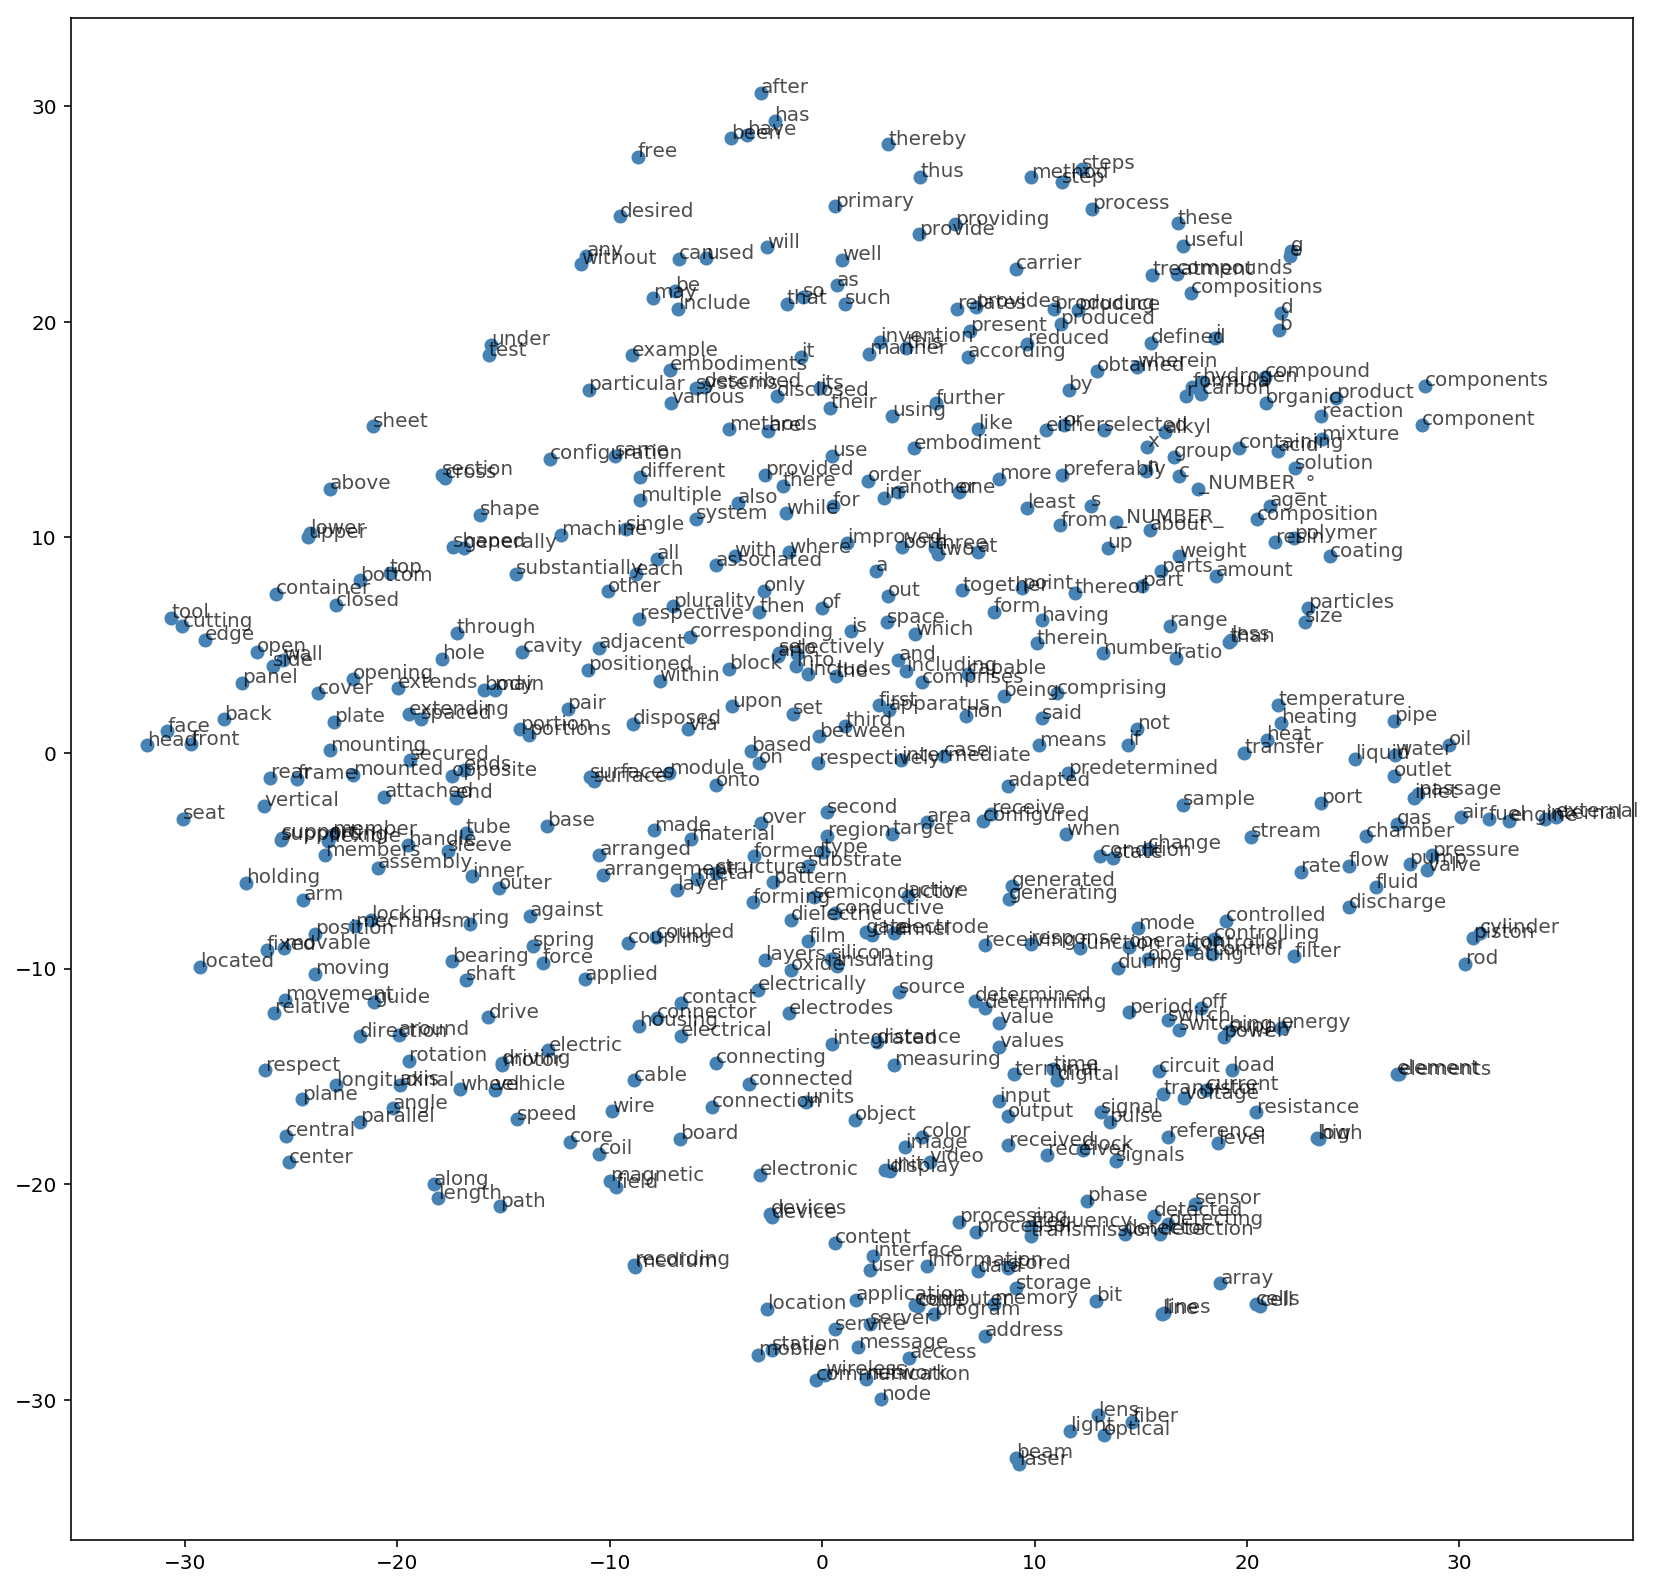

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

### Construct Query

In [98]:
where_clause = ",".join("'" + seed_df.PubNum + "'")
seed_patents_query = '''
SELECT
    REGEXP_EXTRACT(LOWER(publication_number), r'[a-z]+-(\d+)-[a-z0-9]+') as pub_num,
    publication_number,
    family_id,
    priority_date,
    abstract_lang.language AS abstract_lang,
    claims_lang.language AS claims_lang,
    description_lang.language AS description_lang,
    abstract.text as abstract_text,
    claims.text as claims_text,
    description.text as description_text
FROM
  `patent-landscape-165715.patents.publications_latest_copy`,
  UNNEST(abstract_localized) AS abstract,
  UNNEST(claims_localized) AS claims,
  UNNEST(description_localized) AS description,
  UNNEST(abstract_localized) AS abstract_lang,
  UNNEST(claims_localized) AS claims_lang,
  UNNEST(description_localized) AS description_lang
WHERE
country_code = 'US'
AND abstract_lang.language = 'en'
AND claims_lang.language = 'en'
AND description_lang.language = 'en'
AND REGEXP_EXTRACT(publication_number, r'\w+-(\d+)-\w+') IN
(
{}
)
;
'''.format(where_clause)

print(seed_patents_query)


SELECT
    REGEXP_EXTRACT(LOWER(publication_number), r'[a-z]+-(\d+)-[a-z0-9]+') as pub_num,
    publication_number,
    family_id,
    priority_date,
    abstract_lang.language AS abstract_lang,
    claims_lang.language AS claims_lang,
    description_lang.language AS description_lang,
    abstract.text as abstract_text,
    claims.text as claims_text,
    description.text as description_text
FROM
  `patent-landscape-165715.patents.publications_latest_copy`,
  UNNEST(abstract_localized) AS abstract,
  UNNEST(claims_localized) AS claims,
  UNNEST(description_localized) AS description,
  UNNEST(abstract_localized) AS abstract_lang,
  UNNEST(claims_localized) AS claims_lang,
  UNNEST(description_localized) AS description_lang
WHERE
country_code = 'US'
AND abstract_lang.language = 'en'
AND claims_lang.language = 'en'
AND description_lang.language = 'en'
AND REGEXP_EXTRACT(publication_number, r'\w+-(\d+)-\w+') IN
(
'6819790','20090182693','7454388','20080319933','20070011119','8010468','75

In [2]:
path = "shakespeare_input.txt"
char_idx_file = 'char_idx.pickle'

if not os.path.isfile(path):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/tflearn/tflearn.github.io/master/resources/shakespeare_input.txt", path)

maxlen = 25

char_idx = None
if os.path.isfile(char_idx_file):
  print('Loading previous char_idx')
  char_idx = pickle.load(open(char_idx_file, 'rb'))

X, Y, char_idx = \
    textfile_to_semi_redundant_sequences(path, seq_maxlen=maxlen, redun_step=3,
                                         pre_defined_char_idx=char_idx)

pickle.dump(char_idx, open(char_idx_file,'wb'))


Loading previous char_idx
Vectorizing text...
Text total length: 4,573,338
Distinct chars   : 67
Total sequences  : 1,524,438


In [3]:
g = tflearn.input_data([None, maxlen, len(char_idx)])
g = tflearn.lstm(g, 512, return_seq=True)
g = tflearn.dropout(g, 0.5)
g = tflearn.lstm(g, 512, return_seq=True)
g = tflearn.dropout(g, 0.5)
g = tflearn.lstm(g, 512)
g = tflearn.dropout(g, 0.5)
g = tflearn.fully_connected(g, len(char_idx), activation='softmax')
g = tflearn.regression(g, optimizer='adam', loss='categorical_crossentropy',
                       learning_rate=0.001)

m = tflearn.SequenceGenerator(g, dictionary=char_idx,
                              seq_maxlen=maxlen,
                              clip_gradients=5.0,
                              checkpoint_path='model_shakespeare')


In [4]:
# Generate sequences
for i in range(50):
    seed = random_sequence_from_textfile(path, maxlen)
    m.fit(X, Y, validation_set=0.1, batch_size=128,
          n_epoch=1, run_id='shakespeare')
    print("-- TESTING...")
    print("-- Test with temperature of 1.0 --")
    print(m.generate(600, temperature=1.0, seq_seed=seed))
    print("-- Test with temperature of 0.5 --")
    print(m.generate(600, temperature=0.5, seq_seed=seed))



Training Step: 535949  | total loss: 1.27719 | time: 491.669s
| Adam | epoch: 050 | loss: 1.27719 -- iter: 1371904/1371994
Training Step: 535950  | total loss: 1.27454 | time: 526.441s
| Adam | epoch: 050 | loss: 1.27454 | val_loss: 1.16519 -- iter: 1371994/1371994
--
INFO:tensorflow:/usr/local/google/home/feltenberger/src/models/patent-lstm/model_shakespeare-535950 is not in all_model_checkpoint_paths. Manually adding it.
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'list' object has no attribute 'name'
-- TESTING...
-- Test with temperature of 1.0 --
eaner creatures kings.

KING EDWARD IV:
Then, functed and lamentations,
of liberties, from Antonio.

Abried.

DICK:

PISTOL:
Art thou king she wen

In [7]:
print("-- Test with temperature of 1.0 --")
print(m.generate(600, temperature=1.0, seq_seed=seed))


-- Test with temperature of 1.0 --


/usr/local/google/home/feltenberger/anaconda3/envs/tensorflow-gpu/lib/python3.5/site-packages/tflearn/models/generator.py:333: RuntimeWarning: divide by zero encountered in log
  a = np.log(a) / temperature


eaner creatures kings.

KING:
Mine, further, indeed they do may me child, the virtue and obning with a wood;
And my master now the country out of so good for world,
We will fetch in Cassio with the Volsis-stick: 'tis a tomb,
With a shameful precious tongue:
Yonder caught the horses of my desires, old man for the sudden
Of heaven sets as from Peter
So flattering, get me word:
the caret to come you in begot in a little lateness-as away to tender
rash as fools out of my heart breaks set business,
Counterwail you, by your victory?

OLIVIA:
And what saying, madam, there were full of all,
As many some courtesy and terrible 
